# Practice Project 6 - Advertising Sales Channel Prediction

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import ShuffleSplit,cross_val_score
import joblib

import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
df = pd.read_csv('advertising.csv')
df.head(10)

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
5,6,8.7,48.9,75.0,7.2
6,7,57.5,32.8,23.5,11.8
7,8,120.2,19.6,11.6,13.2
8,9,8.6,2.1,1.0,4.8
9,10,199.8,2.6,21.2,10.6


In [3]:
df.shape

(200, 5)

In [4]:
# dropping irrelevant column
df.drop(columns = 'Unnamed: 0',inplace = True)
df

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


## DataFrame Description

When a company enters a market, the distribution strategy and channel it uses are keys to its success in the market, as well as market know-how and customer knowledge and understanding. Because an effective distribution strategy under efficient supply-chain management opens doors for attaining competitive advantage and strong brand equity in the market, it is a component of the marketing mix that cannot be ignored.
<br><br>
The distribution strategy and the channel design have to be right the first time. The case study of Sales channel includes the detailed study of TV, radio and newspaper channel. 

**Features:**
1. TV - amount spent on advertising on TV
2. radio - amount spent on advertising on radio
3. newspaper - amount spent on advertising on newspaper

**Label:** 

- sales - total sales made as a response to the combinations of amounts spend on advertising on media/ channels

## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [6]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [7]:
df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [8]:
(df==0).sum()

TV           0
radio        1
newspaper    0
sales        0
dtype: int64

## Relationship between dependent and independent variables

<AxesSubplot:xlabel='sales', ylabel='Density'>

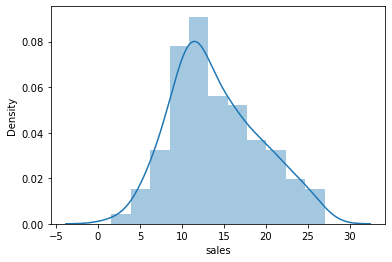

In [9]:
# Sales
sns.distplot(df['sales'])

In [10]:
df['sales'].skew()

0.4075714250767127

**Finding:** Sales data appears to have a fairly normal distribution.

In [11]:
X = df.drop(columns = ['sales'])
y = df['sales']

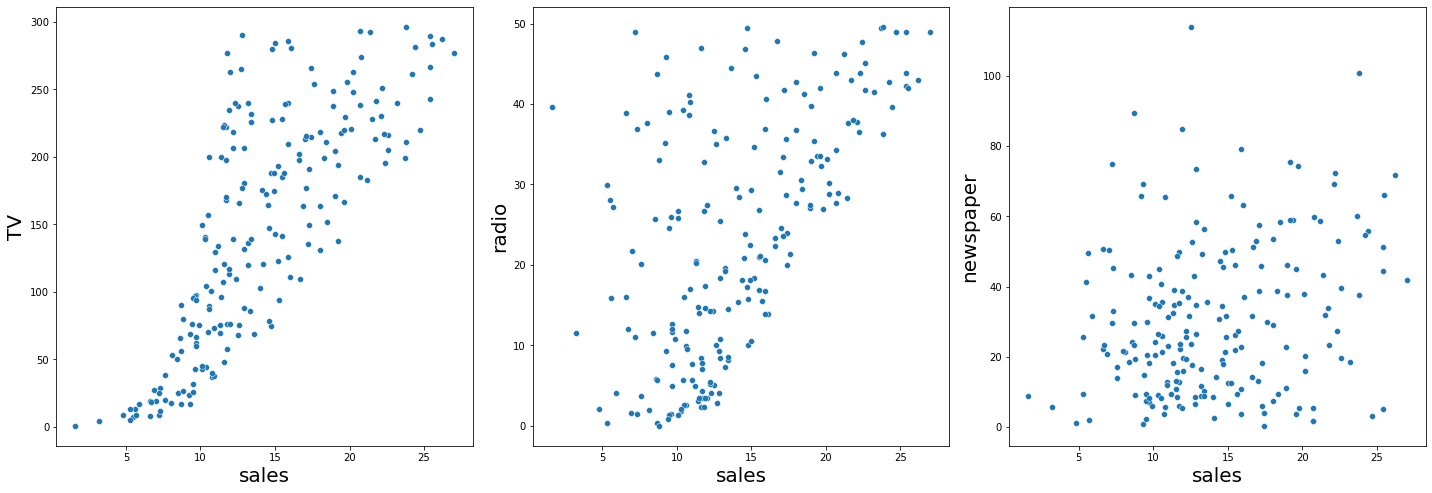

In [12]:
plt.figure(figsize=(20,20))
plotnum=1

for col in X:
    if plotnum<=8:
        plt.subplot(3,3,plotnum)
        sns.scatterplot(y,X[col])
        plt.xlabel('sales',fontsize=20)
        plt.ylabel(col,fontsize=20)
    plotnum+=1
plt.tight_layout()

**Finding:** Positive linear relationships between TV-sales and radio-sales.

<Figure size 1440x1800 with 0 Axes>

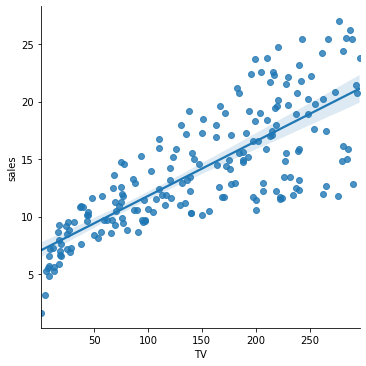

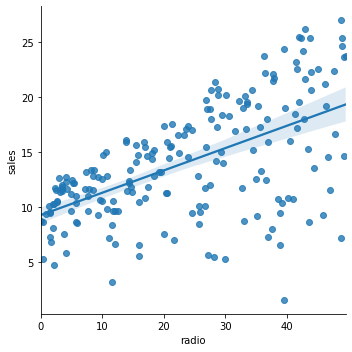

In [13]:
plt.figure(figsize=(20,25))

sns.lmplot(x = 'TV', y ='sales',data = df)
sns.lmplot(x = 'radio', y ='sales',data = df)
plt.tight_layout()

## Establishing Correlation

In [14]:
df_corr = df.corr()
df_corr

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


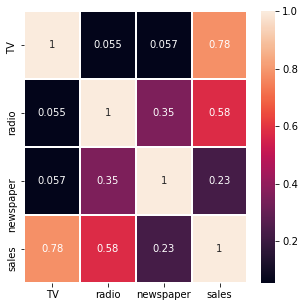

In [16]:
plt.figure(figsize=(5,5))
sns.heatmap(df_corr,annot=True,linewidth=1)
plt.show()

**Findings:**
1. Expenditure on "TV" ads has the highest correlation with "sales".
2. Expenditure on "radio" ads has the second highest (good) correlation with "sales".
3. Expenditure on "newspaper" ads has the lowest correlation with "sales" and weakly positive.

## Correlation of features with label

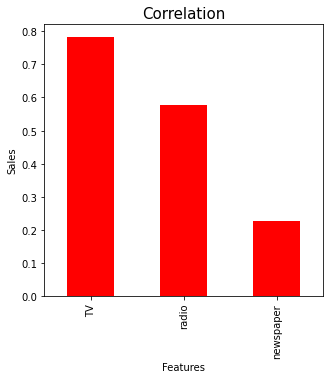

In [17]:
plt.figure(figsize = (5,5))
df.corr()['sales'].sort_values(ascending = False).drop(['sales']).plot(kind='bar',color = 'r')
plt.xlabel('Features',fontsize=10)
plt.ylabel('Sales',fontsize=10)
plt.title('Correlation',fontsize = 15)
plt.show()

**Findings:** All features have a positive correlation with "sales", with TV having the highest correlation, followed by radio and newspaper.

## Skewness Check

In [18]:
df.skew()

TV          -0.069853
radio        0.094175
newspaper    0.894720
sales        0.407571
dtype: float64

**Finding:** It appears the data distribution in "newspaper" is skewed.

<AxesSubplot:xlabel='newspaper', ylabel='Density'>

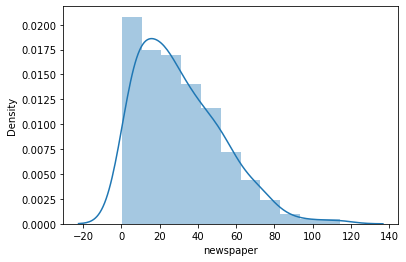

In [22]:
sns.distplot(df['newspaper'])

**Finding:** It appears the data distribution in "newspaper" is right skewed or positively skewed.

## Outliers Check

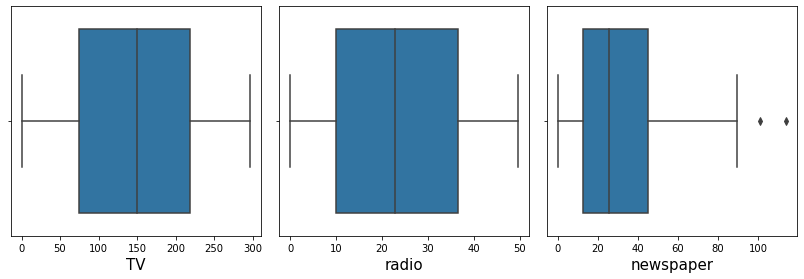

In [24]:
plt.figure(figsize=(15,15))
plotnum=1

for col in X:
    if plotnum<=8:
        plt.subplot(4,4,plotnum)
        sns.boxplot(X[col])
        plt.xlabel(col,fontsize=15)
        
    plotnum+=1
plt.tight_layout()

**Finding:** "newspaper" has some outliers, which may be removed using the IQR / z score method.

#### IQR

In [25]:
df2 = df.copy()

In [26]:
index_drop = np.array([])

q1 = df2['newspaper'].quantile(0.25)
q3 = df2['newspaper'].quantile(0.75)
iqr = q3-q1
upper_value = q3 + (1.5*iqr)
lower_value = q1 - (1.5*iqr)
col =  df2['newspaper']
indx = col[(col > upper_value) | (col < lower_value)].index
index_drop = np.append(index_drop, indx)

In [27]:
index_drop

array([ 16., 101.])

In [28]:
df2 = df2.drop(indx)

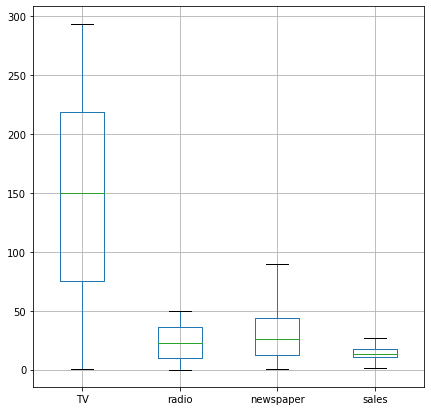

In [29]:
df2.boxplot(figsize=[7,7])
plt.show()

In [30]:
df2.shape

(198, 4)

In [31]:
df.shape

(200, 4)

In [32]:
# data loss
loss=(200-198)/200 * 100
loss

1.0

#### Z score

In [33]:
df3 = df.copy()

In [34]:
zscor = zscore(df3)
z_score_abs = np.abs(zscor)

df4 = df3[(z_score_abs < 3).all(axis=1)]

In [35]:
df4.shape

(198, 4)

In [36]:
# data loss
loss=(200-198)/200 * 100
loss

1.0

In [37]:
df = df2.copy()

In [38]:
df.shape

(198, 4)

In [39]:
df.skew()

TV          -0.082332
radio        0.114842
newspaper    0.650112
sales        0.407130
dtype: float64

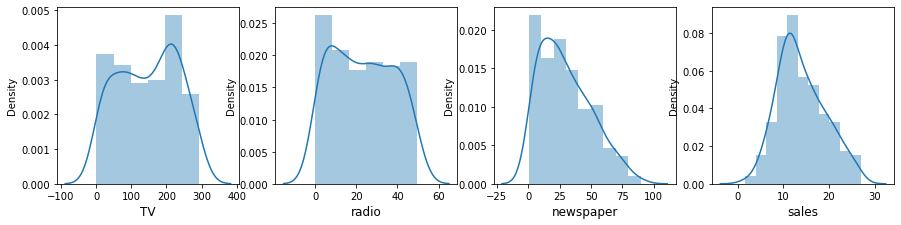

In [41]:
plt.figure(figsize=(15,15))
plotnum=1
for col in df:
    if plotnum<=10:
        plt.subplot(4,4,plotnum)
        sns.distplot(df[col])
        plt.xlabel(col,fontsize=12)
    plotnum+=1
plt.show()

Skewness has been removed to some extent.

## Normalizing data distribution (using Power Transformer)

In [43]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)

In [44]:
skew = ['newspaper']

In [45]:
df5 = df[skew]

In [46]:
df5

,newspaper
0,69.2
1,45.1
2,69.3
3,58.5
4,58.4
...,...
195,13.8
196,8.1
197,6.4
198,66.2


In [47]:
trans = pt.fit_transform(df5)

In [48]:
type(trans)

numpy.ndarray

In [49]:
# converting array into dataframe
trans = pd.DataFrame(trans, columns=df5.columns)

In [50]:
trans.isnull().sum()

newspaper    0
dtype: int64

In [51]:
trans.skew()

newspaper   -0.101288
dtype: float64

In [52]:
trans.index = df.index

In [53]:
df[skew] = trans[skew]

In [54]:
df.skew()

TV          -0.082332
radio        0.114842
newspaper   -0.101288
sales        0.407130
dtype: float64

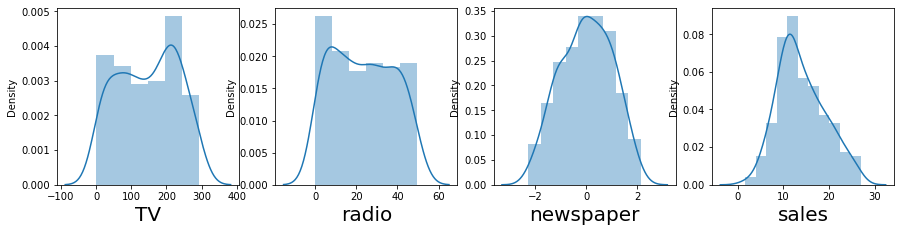

In [55]:
plt.figure(figsize=(15,15))
plotnum=1
for col in df:
    if plotnum<=10:
        plt.subplot(4,4,plotnum)
        sns.distplot(df[col])
        plt.xlabel(col,fontsize=20)
    plotnum+=1
plt.show()

**Result:** Data Distributions have been normalized.

## Splitting Dataset into features and label

In [56]:
X = df.drop(columns = 'sales')
y = df['sales']

## Feature Selection

In [57]:
scaler= StandardScaler()
scaled_X = scaler.fit_transform(X)

In [58]:
scaled_X

array([[ 0.97869734,  0.98952135,  1.6041965 ],
       [-1.19901165,  1.09070498,  0.83104401],
       [-1.51933199,  1.53591293,  1.60705249],
       [ 0.05645636,  1.22561648,  1.28376774],
       [ 0.40024339, -0.83178391,  1.28062154],
       [-1.61906543,  1.73828018,  1.76610727],
       [-1.04647815,  0.6522426 , -0.10205346],
       [-0.31079737, -0.23817331, -0.84968895],
       [-1.62023876, -1.41864895, -2.09866461],
       [ 0.62317696, -1.38492107, -0.22649933],
       [-0.94557138, -1.16906267, -0.06553382],
       [ 0.79800381,  0.05863199, -1.59608414],
       [-1.44189191,  0.80739083,  1.50859232],
       [-0.57714432, -1.04764232, -1.23269654],
       [ 0.67363035,  0.65898817,  0.86367455],
       [ 0.57155024,  1.65733328,  1.1026083 ],
       [ 1.58061798,  1.1109417 ,  1.19771741],
       [-0.90919801, -0.17746313, -0.39458775],
       [ 0.0071763 ,  0.05188642, -0.346834  ],
       [ 0.84141719,  0.30821827,  1.11921444],
       [ 1.06435076, -1.21628169, -0.102

## Multicollinearity Check using VIF

In [59]:
vif = pd.DataFrame()

In [60]:
vif["Features"] = X.columns
vif['vif'] = [variance_inflation_factor(scaled_X,i) for i in range(scaled_X.shape[1])]

In [61]:
vif

,Features,vif
0,TV,1.003286
1,radio,1.098426
2,newspaper,1.097067


**Finding:** There appears to be no multicollinearity in the dataset features.

## Selecting K Best Features

In [62]:
best_features = SelectKBest(score_func = f_classif, k = 3)
fit = best_features.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [63]:
fit = best_features.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
dfcolumns.head()
featureScores = pd.concat([dfcolumns,dfscores],axis = 1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(10,'Score'))

     Feature     Score
0         TV  3.672431
1      radio  1.717044
2  newspaper  1.259850


## Model Building - `Regression Models`

In [64]:
x_train,x_test,y_train,y_test = train_test_split(scaled_X,y,test_size = .25, random_state = 1)

In [65]:
lr = LinearRegression()
rf = RandomForestRegressor()
svr = SVR()
ridge = Ridge()
lasso = Lasso()

#### `Training the models`

In [66]:
lr.fit(x_train,y_train)

LinearRegression()

In [67]:
rf.fit(x_train,y_train)

RandomForestRegressor()

In [68]:
svr.fit(x_train,y_train)

SVR()

In [69]:
ridge.fit(x_train,y_train)

Ridge()

In [70]:
lasso.fit(x_train,y_train)

Lasso()

In [76]:
print("-"*50)
print("Linear Regression Model")
print("-"*50)
lr_pred = lr.predict(x_test)
print("R2 Score: ", r2_score(y_test,lr_pred), "\n")
print("Mean Squared Error: ", mean_squared_error(y_test,lr_pred), "\n"*2)

print("-"*50)
print("Random Forest Model")
print("-"*50)
rf_pred = rf.predict(x_test)
print("R2 Score: ", r2_score(y_test,rf_pred), "\n")
print("Mean Squared Error: ", mean_squared_error(y_test,rf_pred), "\n"*2)

print("-"*50)
print("Support Vector Regression Model")
print("-"*50)
svr_pred = svr.predict(x_test)
print("R2 Score: ", r2_score(y_test,svr_pred), "\n")
print("Mean Squared Error: ", mean_squared_error(y_test,svr_pred), "\n"*2)

print("-"*50)
print("Ridge Model")
print("-"*50)
ridge_pred = ridge.predict(x_test)
print("R2 Score: ", r2_score(y_test,ridge_pred), "\n")
print("Mean Squared Error: ", mean_squared_error(y_test,ridge_pred), "\n"*2)

print("-"*50)
print("Lasso Model")
print("-"*50)
lasso_pred = lasso.predict(x_test)
print("R2 Score: ", r2_score(y_test,lasso_pred), "\n")
print("Mean Squared Error: ", mean_squared_error(y_test,lasso_pred), "\n"*2)

--------------------------------------------------
Linear Regression Model
--------------------------------------------------
R2 Score:  0.9019418610387824 

Mean Squared Error:  2.412327884352358 


--------------------------------------------------
Random Forest Model
--------------------------------------------------
R2 Score:  0.9845961423675691 

Mean Squared Error:  0.3789502400000012 


--------------------------------------------------
Support Vector Regression Model
--------------------------------------------------
R2 Score:  0.9436568369727288 

Mean Squared Error:  1.3860979282612453 


--------------------------------------------------
Ridge Model
--------------------------------------------------
R2 Score:  0.9032688640847263 

Mean Squared Error:  2.379682287727105 


--------------------------------------------------
Lasso Model
--------------------------------------------------
R2 Score:  0.8596283763111786 

Mean Squared Error:  3.4532817528821993 




## Model Cross Validation

In [77]:
print("Cross Validation Score for Linear Regression Model: ", cross_val_score(lr,scaled_X,y,cv=5).mean(), "\n"*2)
print("Cross Validation Score for Random Forest Model: ", cross_val_score(rf,scaled_X,y,cv=5).mean(), "\n"*2)
print("Cross Validation Score for Support Vector Regression Model: ", cross_val_score(svr,scaled_X,y,cv=5).mean(), "\n"*2)
print("Cross Validation Score for Ridge Model: ", cross_val_score(ridge,scaled_X,y,cv=5).mean(), "\n"*2)
print("Cross Validation Score for Lasso Model: ", cross_val_score(lasso,scaled_X,y,cv=5).mean())

Cross Validation Score for Linear Regression Model:  0.8857739370001966 


Cross Validation Score for Random Forest Model:  0.9753331536422154 


Cross Validation Score for Support Vector Regression Model:  0.9036275725678571 


Cross Validation Score for Ridge Model:  0.885861065285637 


Cross Validation Score for Lasso Model:  0.8163649691832717


**Findings:** Based on the results of the **`R2 scores`** and **`Cross Validation scores`**, it is evident that **`Random Forest`** is the best model.

## Hyperparameter Tuning

In [78]:
parameters = {'n_estimators':[20,30,50,60],
              'max_depth': [10,20,30,40],
              'min_samples_leaf':[5,10,15,20],
              'min_samples_split':[3,5,8,10],
              'criterion':['mse','mae'],
              'max_features':["auto","sqrt","log2"]
             }

In [79]:
GridCV = GridSearchCV(RandomForestRegressor(),parameters,cv=5,n_jobs = -1,verbose = 1)

In [80]:
GridCV.fit(x_train,y_train)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [10, 20, 30, 40],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [3, 5, 8, 10],
                         'n_estimators': [20, 30, 50, 60]},
             verbose=1)

In [81]:
GridCV.best_params_

{'criterion': 'mse',
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 30}

In [82]:
Best_mod = RandomForestRegressor(n_estimators = 30,
                                 criterion = 'mse',
                                 max_depth= 30,
                                 max_features = 'auto',
                                 min_samples_leaf = 5,
                                 min_samples_split = 10)

In [83]:
Best_mod.fit(x_train,y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=30)

In [84]:
rfpred = Best_mod.predict(x_test)
acc = r2_score(y_test,rfpred)
print(acc*100)

97.35871264195453


## `Random Forest Regressor` has an accuracy of `97.36%`

## Saving the model

In [85]:
joblib.dump(Best_mod,"Advertising_Sales_Channel_Prediction.pkl")

['Advertising_Sales_Channel_Prediction.pkl']

In [86]:
mod=joblib.load("Advertising_Sales_Channel_Prediction.pkl")

print(mod.predict(x_test))

[12.5153992  18.15318845 12.08075986  7.85309031 24.21293306 16.16822963
 11.6036459  14.00167275 19.09487043 14.46085093 19.19506864 15.08901105
 16.97726393 17.7236868  10.37722391  7.11532339  9.99273686 24.26357635
 14.49896156 18.85621428 22.64474339 22.82064393 15.93827651 12.66403845
 10.03871977 11.19207827 21.55160676 11.10857855 12.41180061 18.97370376
 15.37617285  7.84330686  9.04422467 11.1653005  14.85373286 19.90800607
 10.33124508 11.82858591 11.3807696  15.93496841 18.93199721  6.23880105
 13.78123455 19.58857045 12.54166084 18.64649537 17.28654964 16.5858124
 10.29653471 10.30483029]


# `END`